# 5.0 Creating Pipelines

### In this notebook will create two functions i.e function_1 and function_2
### 
In function_1 will create entire pipeline to predict the output i.e for any given query will predict the output of it.
### 
In function_2 will create entire pipeline to output the performance metric

In [15]:
#importing neccessary libraries
import warnings
warnings.filterwarnings("ignore")
import re
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
import pickle
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
try:
    with open('train_bow', 'rb') as f:
        train_bow = pickle.load(f)
        print("Opened successfully")
except Exception as e:
    print("File cannot open. Error:", e)


Opened successfully


In [31]:
#to print the classification metrics
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = [0,1]
    plt.figure(figsize = (20,5))
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    
    
    plt.show()
    print("f1-score on the data is  {}".format(f1_score(test_y,predict_y)))
    print("Run Successfully")

In [33]:
# 5.1 Function_1 will output the prediction whether it belongs to class 1 or class 0 for a given SQL Query

In [35]:
def preprocess(query):
    preprocessed_query = []
    
    def process(x,pattern):
        r = re.compile(pattern)
        l = r.findall(x)
        return len(l)
    
    def combined_keywords(x):
        r = re.compile(r'null')
        m = re.compile(r'chr')
        n = re.compile(r'char')
        l = r.findall(x)
        k = m.findall(x)
        j = n.findall(x)
        return len(l) + len(k) + len(j)
    
    def genuine(x):
        count = 0
        genuine_keys = ['select','top','order','fetch','join','avg','count','sum','rows']
        for i in x.split():
            if(i in genuine_keys):
                count = count + 1
        return count
    
    preprocessed_query.append(process(query,"'"))
    preprocessed_query.append(process(query,'"'))
    preprocessed_query.append(process(query,"[!\"#$%&\'()*+,-.\/:;<=>?@[\\]^_`{|}~]"))
    preprocessed_query.append(process(query,'(--)'))
    preprocessed_query.append(process(query,'(\/\*)'))
    preprocessed_query.append(process(query,'\s+'))
    preprocessed_query.append(process(query,"%"))
    preprocessed_query.append(process(query,'\snot\s|\sand\s|\sor\s|\sxor\s|&&|\|\||!'))
    preprocessed_query.append(process(query,"'\+|-|[^\/]\*|\/[^\*]'"))
    preprocessed_query.append(process(query,"null"))
    preprocessed_query.append(process(query,'0[xX][0-9a-fA-F]+\s'))
    preprocessed_query.append(process(query,'[a-zA-Z]'))
    preprocessed_query.append(process(query,'[0-9]'))
    preprocessed_query.append(combined_keywords(query))
    preprocessed_query.append(genuine(query))
    
    return preprocessed_query
    

In [37]:
def final_function_1(query):
    li = []
    query = query.lower()#converting query to lowercase
    arr = preprocess(query)#preprocessing the query
    li.append(query)
    unigram_bow = train_bow.transform(li)
    
    combine = hstack((unigram_bow,arr))
    
    #loading the model
    xgboost_model = joblib.load('saved_model_unigram_bow.pkl')
    
    #predicting the output from the loaded model
    predict = xgboost_model.predict(combine)
    
    for i in predict:
        if(i == 1):
              print("the query passed belongs to class {} i.e the query is SQL injection query".format(i))
        else:
              print("the query passed belongs to class {} i.e the query is not a  SQL injection query".format(i))
    final_function_1("select   (  case when   (  1275  =  7674  )   then 1275 else 1275*  (  select 1275 from information_schema.character_sets  )   end  )  #")
    

In [39]:
#define the function_1
def function_1(query):
    '''
    query parameter is a list of queries given to predict that it is Sql injection or not.
    
    '''
    #first will create the dataframe for list of queries
    data = pd.DataFrame()
    data['Query'] = query
    
    #convert the query to lowercase sentence
    data['Query'] = data['Query'].apply(lambda x : x.lower())
    
                
    #number of single quotation in a query
    def single_qt(x):
        r = re.compile(r"'")
        l = r.findall(x)
        return len(l)
    data['no_single_qts'] = data['Query'].apply(single_qt)


    #number of double quotation in a query
    def double_qt(x):
        r = re.compile(r'"')
        l = r.findall(x)
        return len(l)
    data['no_double_qts'] = data['Query'].apply(double_qt)

     #number of punctuations 
    def punctuation(x):
        r = re.compile("[!\"#$%&\'()*+,-.\/:;<=>?@[\\]^_`{|}~]")
        l = r.findall(x)
        return len(l)
    data['no_punct'] = data['Query'].apply(punctuation)


    #number of single line comment
    def sin_comm(x):
        r = re.compile(r'(--)')
        l = r.findall(x)
        return len(l)
    data['no_single_cmnt'] = data['Query'].apply(sin_comm)

    #number of multiline comments
    def mult_comm(x):
        r = re.compile(r'(\/\*)')
        l = r.findall(x)
        return len(l)
    data['no_mult_cmnt'] = data['Query'].apply(mult_comm)


     #number of white spaces in a query
    def space(x):
        r = re.compile(r'\s+')
        l = r.findall(x)
        return len(l)
    data['no_space'] = data['Query'].apply(space) 


     #number of percentage(%) symbols in a query.
    def perc(x):
        r = re.compile(r'%')
        l = r.findall(x)
        return len(l)
    data['no_perc'] = data['Query'].apply(perc)


      #total number of logical operator in a query
         #logical operators are and,or,not,xor,&&,||,!
      #https://stackoverflow.com/questions/43079182/how-to-find-logic-operators-in-string-with-regex
    def logical(x):
        r = re.compile(r'\snot\s|\sand\s|\sor\s|\sxor\s|&&|\|\||!')
        l = r.findall(x)
        return len(l)
    data['no_log_opt'] = data['Query'].apply(logical)


      #total number of arithmetic operators
    def arithmetic(x):
        r = re.compile(r'\+|-|[^\/]\*|\/[^\*]')
        l = r.findall(x)
        return len(l)
    data['no_arith'] = data['Query'].apply(arithmetic)


       #number of null values in a query
    def null_val(x):
        r = re.compile(r'null')
        l = r.findall(x)
        return len(l)
    data['no_null'] = data['Query'].apply(null_val)


     #number of hexadecimal values
    def hexa(x):
        r = re.compile(r'0[xX][0-9a-fA-F]+\s')
        l = r.findall(x)
        return len(l)
    data['no_hexa'] = data['Query'].apply(hexa)


    #number of alphabets
    def alphabet(x):
        r = re.compile(r'[a-zA-Z]')
        l = r.findall(x)
        return len(l)
    data['no_alpha'] = data['Query'].apply(alphabet)


     #number of digits
    def digit(x):
        r = re.compile(r'[0-9]')
        l = r.findall(x)
        return len(l)
    data['no_digit']  =data['Query'].apply(digit)


       #length of chr+char+null keywords
    def combined_keywords(x):
        r = re.compile(r'null')
        m = re.compile(r'chr')
        n = re.compile(r'char')
        l = r.findall(x)
        k = m.findall(x)
        j = n.findall(x)
        return len(l) + len(k) + len(j)
    data['len_of_chr_char_null'] = data['Query'].apply(combined_keywords)


     #genuine_keywords
     #genuine keywords are based on wordclouds : select,top,order,fetch,join,avg,count,sum,rows.
     #will check how many number of these keywords are present in each query.

    def genuine(x):
        count = 0
        genuine_keys = ['select','top','order','fetch','join','avg','count','sum','rows']
        for i in x.split():
            if(i in genuine_keys):
                count = count + 1
        return count

    data['genuine_keywords'] = data['Query'].apply(genuine)
        
    #because in the model building we come to know that unigram BOW encoding provides better f1-score
    unigram_bow = train_bow.transform(data['Query'].values)
    
 
    #finally will concatenate unigram_bow and above generated features
    data_bow_unigram = hstack((unigram_bow,np.array(data['no_single_qts']).reshape(-1,1),np.array(data['no_double_qts']).reshape(-1,1),np.array(data['no_punct']).reshape(-1,1),np.array(data['no_single_cmnt']).reshape(-1,1),np.array(data['no_mult_cmnt']).reshape(-1,1),np.array(data['no_space']).reshape(-1,1),np.array(data['no_perc']).reshape(-1,1),np.array(data['no_log_opt']).reshape(-1,1),np.array(data['no_arith']).reshape(-1,1),np.array(data['no_null']).reshape(-1,1),np.array(data['no_hexa']).reshape(-1,1),np.array(data['no_alpha']).reshape(-1,1),np.array(data['no_digit']).reshape(-1,1),np.array(data['len_of_chr_char_null']).reshape(-1,1),np.array(data['genuine_keywords']).reshape(-1,1)))
    #loading the XGboost model for unigram bow encoding
    xgboost_model = joblib.load('saved_model_unigram_bow.pkl')
    
    #predicting the output from the loaded model
    predict = xgboost_model.predict(data_bow_unigram)
    
    for i in range(len(predict)):
        if(predict[i] == 1):
            print("the {} query passed belongs to class {} i.e the query is SQL injection query".format(i,predict[i]))
        else:
            print("the {} query passed belongs to class {} i.e the query is not a  SQL injection query".format(i,predict[i]))
    return predict
    function_1(["create user name identified by pass123 temporary tablespace temp default tablespace users;"," or pg_sleep ( __TIME__ ) --","SELECT sure FROM silent UNION SELECT sides FROM excellent ORDER BY wing"])

# 5.2 function_2 will output the classification metrics for given list of query and labels

the 0 query passed belongs to class 1 i.e the query is SQL injection query
the 1 query passed belongs to class 1 i.e the query is SQL injection query
the 2 query passed belongs to class 1 i.e the query is SQL injection query
the 3 query passed belongs to class 1 i.e the query is SQL injection query
the 4 query passed belongs to class 1 i.e the query is SQL injection query
the 5 query passed belongs to class 1 i.e the query is SQL injection query


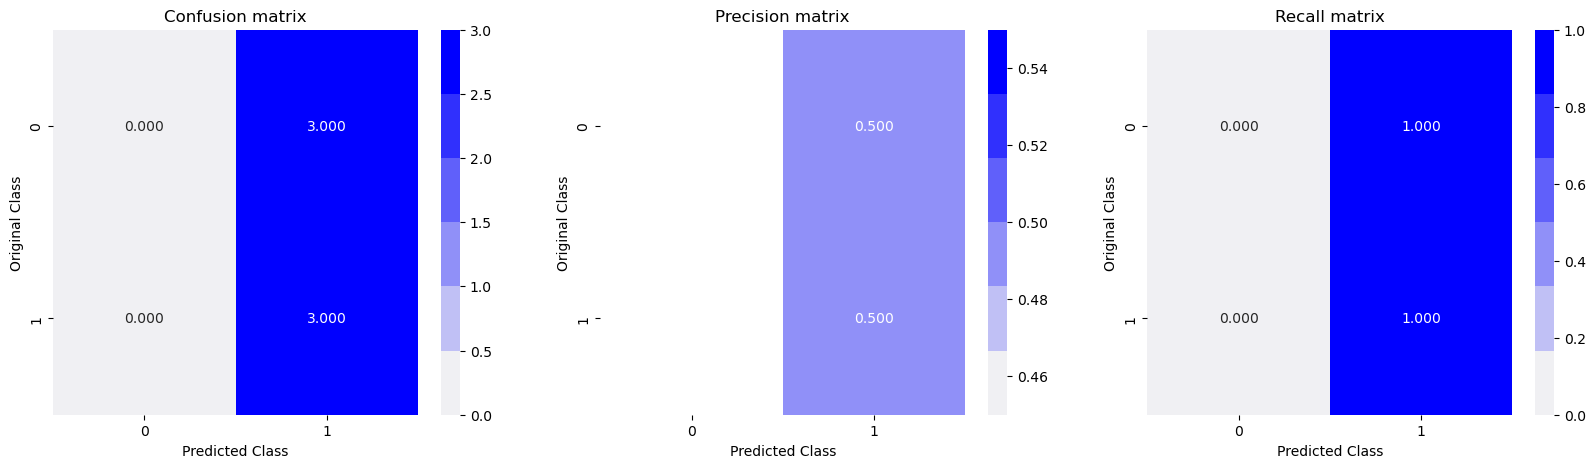

f1-score on the data is  0.6666666666666666
Run Successfully


In [41]:
def final_function_2(data):
    '''
    data parameter is a list of tuples where 1st argument is sql query and respective labels
    
    '''
    
    #first will separate query and labels store it in separate lists
    query = []
    labels = []
    for i in data:
        query.append(i[0])
        labels.append(i[1])
    
    #will call function_1 on above query lists to get predicted labels
    pred_labels = function_1(query)
    plot_confusion_matrix(labels,pred_labels)
    
#calling the function_2 method to print the classification metrics
#first will create list of tuples of queries and labels

data = [("create user name identified by pass123 temporary tablespace temp default tablespace users;",1),
        (" or pg_sleep ( __TIME__ ) --",1),
        ("SELECT sure FROM silent UNION SELECT sides FROM excellent ORDER BY wing",0),
        ('select   (  case when   (  1275  =  7674  )   then 1275 else 1275*  (  select 1275 from information_schema.character_sets  )   end  )  #',1),
        ('otia',0),
        ('joudrey',0)]
         
final_function_2(data)